# Topic Modeling
One of the primary applications of natural language processing is to automatically extract what topics people are discussing from large volumes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, etc, user feedbacks, news stories, e-mails of customer complaints etc.

Topic Modeling is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s packages. The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics. 

Here we tried Gensim and sklearn and the first turns to be a better library in this case.

##  with Gensim

Knowing what papers are talking about and understanding their problems and opinions is highly valuable. And it’s really hard to manually read through such large volumes and compile the topics. Thus is required an automated algorithm that can read through the text documents and automatically output the topics discussed.

In this notebook, the dataset is provided by ICLS abd CSCL which are two conference organized by International Society of Learning Science, and cleaned by Stian Haklev. With some csv file from Abassi Nour Ghalia (nour.abassi@epﬂ.ch) Guillain Léonore Valentine (leonore.guillain@epﬂ.ch) this notebook use LDA to extract the naturally discussed topics.

Mainly, I use the Latent Dirichlet Allocation (LDA) from Gensim package along with the Mallet’s implementation. Then with the help of Dynamic Topic Model(DTL), we can see keywords weight in each topic change through years. Also the Author topic modeling(ATM) which calculate correlation between authors and topics, is also included and draw a authors' preference plot to show their cluster.


### Import Packages
The core packages used are re(for extract specific format text), gensim(model library), spacy(get stem of a word) and pyLDAvis. Besides this we will also using matplotlib, numpy and pandas for data handling and visualization.

In [3]:
# Run in python console
import nltk; nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Other setting
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zhechensu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Prepare Stopwords
Downloaded the stopwords from nltk. And add some specific word we want to filter

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'gmail', 'cscl', 'edu', 'use', 'et_al'])

### Import data from papers
Here we use os.walk go through the data root file and import papers by `parse` function. 

We get a list `contents` as output which has textual data of each pdf. Then tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether, '\n' for example. Gensim’s simple_preprocess() is great for this. Additionally, set deacc=True to remove the punctuations.

The output is stored in `data_words` as a list of words

In [5]:
def parse(file_path): 
    i = 0 
    tmp = ''
    key = ''
    xml2 =etree.iterparse(file_path, recover=True)
    data = []
    for action, elem in xml2:
        data.append((elem.attrib,elem.text))
    data_dict = {}
    l = set()
    for elem in data: 
        try : 
            tmp = key 
            key = elem[0].get('qualifier')
            if key == 'author':
                l.add(elem[1])
                data_dict[key] = l
                if tmp == key:
                    l.add(elem[1])
                    data_dict[key] = l
                else : 
                    l = set()
            else : 
                data_dict[key] = elem[1]
        except TypeError: 
                data_dict['None'] = elem[1]
    return data_dict

In [6]:
import os
rootdir = 'data/papers'
contents = []
i = 0
num_2014 = 0
num_2015 = 0
num_2016 = 0
num_2017 = 0
num_2018 = 0
source = []
errors = []
docid = dict()
for subdir, dirs, files in os.walk(rootdir):
    files.sort()
    for file in files:
        if 'txt' in file:
            if '2014' in file:
                num_2014 += 1
            if '2015' in file:
                num_2015 += 1
            if '2016' in file:
                num_2016 += 1
            if '2017' in file:
                num_2017 += 1
            if '2018' in file:
                num_2018 += 1
            path = os.path.join(subdir, file)
            with open(path) as file:
                try:
                    text = file.read()
                    contents.append(text)
                    docid[i] = [file.name.split('/')[-1].split('.')[0]]
                    source.append(subdir[len(rootdir):])
                    i = i+1
                except:
                    name, message, content = sys.exc_info()
                    errors.append(message)


In [7]:
len(contents)

1125

In [8]:
#get time_slice which is useful for DTM
time_slice = [num_2014,num_2015, num_2016,num_2017, num_2018]
time_slice

[308, 85, 171, 115, 446]

In [9]:
#convert contents to word(tokenize)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(contents))

print(data_words[:1])

[['teaching', 'struggling', 'middle', 'school', 'readers', 'to', 'comprehend', 'informational', 'text', 'donna', 'caccamise', 'angela', 'friend', 'christine', 'groneman', 'megan', 'littrell', 'baez', 'and', 'eileen', 'kintsch', 'university', 'of', 'colorado', 'boulder', 'institute', 'of', 'cognitive', 'science', 'exposition', 'dr', 'boulder', 'colorado', 'email', 'donna', 'caccamise', 'colorado', 'edu', 'angela', 'friend', 'colorado', 'edu', 'christine', 'groneman', 'colorado', 'edu', 'megan', 'littrellbaez', 'colorado', 'edu', 'eileen', 'kintsch', 'colorado', 'edu', 'abstract', 'this', 'project', 'involves', 'developing', 'reading', 'comprehension', 'curriculum', 'based', 'on', 'the', 'construction', 'integration', 'model', 'kintsch', 'and', 'implementing', 'pilot', 'efficacy', 'study', 'in', 'middle', 'school', 'classrooms', 'the', 'curriculum', 'bravo', 'explicitly', 'defines', 'the', 'cognitive', 'processes', 'involved', 'in', 'skilled', 'reading', 'teaching', 'students', 'how', 't

In [10]:
len(data_words)

1125

### Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our context are: ‘problem_solving’, ‘New_york' etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these parameters are, the harder it is for words to be combined to bigrams.

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/Users/zhechensu/anaconda3/envs/ada/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['teaching', 'struggling', 'middle_school', 'readers', 'to', 'comprehend', 'informational_text', 'donna', 'caccamise', 'angela', 'friend', 'christine', 'groneman', 'megan', 'littrell', 'baez', 'and', 'eileen', 'kintsch', 'university', 'of', 'colorado_boulder', 'institute', 'of', 'cognitive', 'science', 'exposition', 'dr', 'boulder_colorado', 'email', 'donna', 'caccamise', 'colorado_edu', 'angela', 'friend', 'colorado_edu', 'christine', 'groneman', 'colorado_edu', 'megan', 'littrellbaez', 'colorado_edu', 'eileen', 'kintsch', 'colorado_edu_abstract', 'this', 'project', 'involves', 'developing', 'reading_comprehension', 'curriculum', 'based', 'on', 'the', 'construction', 'integration', 'model', 'kintsch', 'and', 'implementing', 'pilot', 'efficacy', 'study', 'in', 'middle_school', 'classrooms', 'the', 'curriculum', 'bravo', 'explicitly', 'defines', 'the', 'cognitive', 'processes', 'involved', 'in', 'skilled', 'reading', 'teaching', 'students', 'how', 'to', 'establish', 'local', 'and', 'glo

### Remove Stopwords, Make Bigrams and Lemmatize
The bigrams model is ready.  
Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

import spacy
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out



In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


# Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization_(data_words_bigrams)
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['teach', 'struggle', 'middle_school', 'reader', 'comprehend', 'informational_text', 'donna', 'caccamise', 'angela', 'friend', 'christine', 'groneman', 'megan', 'littrell', 'baez', 'eileen', 'kintsch', 'university', 'colorado_boulder', 'institute', 'cognitive', 'science', 'exposition', 'email', 'donna', 'caccamise', 'colorado', 'angela', 'friend', 'colorado', 'christine', 'groneman', 'colorado', 'megan', 'littrellbaez', 'colorado', 'eileen', 'kintsch', 'colorado', 'abstract', 'project', 'involve', 'develop', 'reading_comprehension', 'curriculum', 'base', 'construction', 'integration', 'model', 'kintsch', 'implement', 'pilot', 'efficacy', 'study', 'middle_school', 'classroom', 'curriculum', 'bravo', 'explicitly', 'define', 'cognitive', 'process', 'involve', 'skilled', 'reading', 'teaching', 'student', 'establish', 'local', 'global', 'text', 'coherence', 'background', 'knowledge', 'create', 'mental', 'model', 'prerequisite', 'deep', 'meaningful', 'learning', 'crucial', 'unique', 'compon

In [14]:
len(data_lemmatized)

1125

### Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them

In [23]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

id2word.filter_extremes(no_below=30, no_above=0.4)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# tfidf = gensim.models.TfidfModel(corpus)

# corpus_tfidf = tfidf[corpus]

# View
print(corpus[:1])


[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 2), (5, 1), (6, 1), (7, 4), (8, 1), (9, 1), (10, 1), (11, 3), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 6), (25, 9), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 7), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 6), (57, 1), (58, 1), (59, 1), (60, 2), (61, 9), (62, 8), (63, 1), (64, 3), (65, 6), (66, 1), (67, 2), (68, 1), (69, 1), (70, 2), (71, 1), (72, 4), (73, 7), (74, 44), (75, 1), (76, 2), (77, 1), (78, 2), (79, 1), (80, 2), (81, 1), (82, 1), (83, 2), (84, 6), (85, 1), (86, 3), (87, 1), (88, 1), (89, 2), (90, 1), (91, 2), (92, 1), (93, 1), (94, 2), (95, 7), (96, 2), (97, 2), (98, 2), (99, 2), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 2), (106, 1), (107, 1), (108, 3), (109, 3), (110, 1

### Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, we need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [24]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/zhechensu/anaconda3/envs/ada/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4      0.055412 -0.013627       1        1  9.214692
13     0.150360 -0.121734       2        1  8.846817
10     0.113842 -0.007649       3        1  7.894372
9      0.090487 -0.178889       4        1  7.544116
6      0.108143  0.108425       5        1  7.339402
7      0.038782  0.206115       6        1  6.444551
17     0.115351  0.139604       7        1  6.026282
8      0.058112 -0.051958       8        1  5.524909
2      0.075939  0.207428       9        1  5.465422
21     0.069687  0.028744      10        1  4.706236
23     0.089174 -0.153181      11        1  4.671958
19     0.103063 -0.066150      12        1  3.952758
20     0.091366 -0.083641      13        1  3.466744
11     0.005693  0.183378      14        1  2.893824
22    -0.171301  0.037149      15        1  2.417009
24     0.098947 -0.070003      16        1  2.293906
14    -0.085106 -0.047367      17        1  1.645249
3     -0.111581  0.098310      18        1  1.645130
16    -0.051220 -0.073813      19        1  1.605147
18     0.030230 -0.054782      20        1  1.431550
15    -0.087478  0.043739      21        1  1.352642
0     -0.123892 -0.131937      22        1  1.293442
5     -0.097731  0.096677      23        1  1.248831
12    -0.317698 -0.059199      24        1  0.731507
1     -0.248582 -0.035640      25        1  0.343499, topic_info=     Category         Freq                 Term        Total  loglift  logprob
527   Default  3241.000000                 game  3241.000000  30.0000  30.0000
747   Default  3744.000000            condition  3744.000000  29.0000  29.0000
392   Default  2090.000000                 text  2090.000000  28.0000  28.0000
267   Default  2013.000000              network  2013.000000  27.0000  27.0000
689   Default  2245.000000                 team  2245.000000  26.0000  26.0000
801   Default  1931.000000              gesture  1931.000000  25.0000  25.0000
1012  Default  1903.000000             feedback  1903.000000  24.0000  24.0000
326   Default  1836.000000                 read  1836.000000  23.0000  23.0000
584   Default  1932.000000           mathematic  1932.000000  22.0000  22.0000
1049  Default  1495.000000               object  1495.000000  21.0000  21.0000
773   Default  1331.000000               energy  1331.000000  20.0000  20.0000
1035  Default  1380.000000         mathematical  1380.000000  19.0000  19.0000
1414  Default  1685.000000           simulation  1685.000000  18.0000  18.0000
621   Default  1090.000000             positive  1090.000000  17.0000  17.0000
1041  Default  1086.000000             movement  1086.000000  16.0000  16.0000
2424  Default  1932.000000          facilitator  1932.000000  15.0000  15.0000
230   Default  1520.000000               lesson  1520.000000  14.0000  14.0000
711   Default  2258.000000                youth  2258.000000  13.0000  13.0000
1226  Default  1749.000000             physical  1749.000000  12.0000  12.0000
1338  Default  1730.000000            epistemic  1730.000000  11.0000  11.0000
511   Default  1614.000000           experiment  1614.000000  10.0000  10.0000
1786  Default  1680.000000          progression  1680.000000   9.0000   9.0000
730   Default  1146.000000                 body  1146.000000   8.0000   8.0000
343   Default  1815.000000       representation  1815.000000   7.0000   7.0000
39    Default  1931.000000             behavior  1931.000000   6.0000   6.0000
956   Default   861.000000               affect   861.000000   5.0000   5.0000
550   Default  1661.000000             identity  1661.000000   4.0000   4.0000
1031  Default  1049.000000                light  1049.000000   3.0000   3.0000
455   Default  1600.000000                 code  1600.000000   2.0000   2.0000
1471  Default  1338.000000          engineering  1338.000000   1.0000   1.0000
...       ...          ...                  ...          ...      ...      ..

### View the topics in LDA model
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

We can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [17]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.025*"tutor" + 0.021*"dyad" + 0.021*"partner" + 0.012*"cluster" + '
  '0.011*"network" + 0.010*"dialogue" + 0.008*"sequence" + 0.007*"phase" + '
  '0.007*"segment" + 0.007*"predict"'),
 (1,
  '0.060*"identity" + 0.029*"stem" + 0.024*"scientist" + 0.019*"gender" + '
  '0.018*"agency" + 0.018*"woman" + 0.017*"disciplinary" + 0.017*"cultural" + '
  '0.012*"power" + 0.011*"career"'),
 (2,
  '0.010*"innovation" + 0.009*"district" + 0.008*"dimension" + 0.007*"tension" '
  '+ 0.007*"designer" + 0.006*"professional" + 0.006*"partnership" + '
  '0.006*"discipline" + 0.006*"mediate" + 0.005*"pedagogical"'),
 (3,
  '0.050*"lesson" + 0.026*"professional_development" + '
  '0.017*"curriculum_material" + 0.016*"formative_assessment" + '
  '0.016*"comment" + 0.014*"collective" + 0.011*"pre_service" + '
  '0.011*"enactment" + 0.010*"pedagogical" + 0.010*"scaffold"'),
 (4,
  '0.031*"epistemic" + 0.025*"argument" + 0.021*"argumentation" + '
  '0.016*"claim" + 0.011*"uncertainty" + 0.008*"criter

### Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is.

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.605390261411451

Coherence Score:  0.41927234844831335


### Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords.

In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/zhechensu/anaconda3/envs/ada/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.080458  0.151387       1        1  13.458152
10     0.140579  0.041322       2        1   9.816174
7     -0.095445  0.067045       3        1   9.613713
4      0.085353  0.097460       4        1   9.307929
12     0.095966  0.003866       5        1   7.618427
0      0.239982  0.035920       6        1   7.139295
6      0.020938  0.011582       7        1   6.462193
13     0.212810 -0.031298       8        1   5.887112
14    -0.002801 -0.020915       9        1   5.772532
9     -0.228393  0.013267      10        1   5.489609
3     -0.027349  0.175045      11        1   4.932080
1     -0.190938 -0.018640      12        1   4.489481
8      0.083434 -0.258119      13        1   3.713666
5     -0.155896 -0.024375      14        1   3.701823
11    -0.097780 -0.243547      15        1   2.597822, topic_info=     Category         Freq                      Term        Total  loglift  \
462   Default  2916.000000                      game  2916.000000  30.0000   
736   Default  2019.000000                   gesture  2019.000000  29.0000   
483   Default  1938.000000                  identity  1938.000000  28.0000   
1386  Default  2176.000000                simulation  2176.000000  27.0000   
642   Default  1861.000000                     youth  1861.000000  26.0000   
184   Default  1787.000000                    lesson  1787.000000  25.0000   
2667  Default  1865.000000               facilitator  1865.000000  24.0000   
1298  Default  1952.000000                 epistemic  1952.000000  23.0000   
1537  Default  2045.000000                      stem  2045.000000  22.0000   
724   Default  1210.000000                    family  1210.000000  21.0000   
981   Default  1636.000000              mathematical  1636.000000  20.0000   
1837  Default  1400.000000               progression  1400.000000  19.0000   
18    Default  1746.000000                  argument  1746.000000  18.0000   
1456  Default  1174.000000               engineering  1174.000000  17.0000   
217   Default  2352.000000                   network  2352.000000  16.0000   
1407  Default  1382.000000                  workshop  1382.000000  15.0000   
709   Default  1276.000000                    energy  1276.000000  14.0000   
2248  Default  1225.000000                     tutor  1225.000000  13.0000   
592   Default   964.000000             self_efficacy   964.000000  12.0000   
657   Default  1364.000000             argumentation  1364.000000  11.0000   
588   Default  1508.000000                 scientist  1508.000000  10.0000   
264   Default  1033.000000  professional_development  1033.000000   9.0000   
977   Default   985.000000                     light   985.000000   8.0000   
946   Default  1037.000000                      dyad  1037.000000   7.0000   
971   Default  1382.000000                      item  1382.000000   6.0000   
58    Default  1063.000000             computational  1063.000000   5.0000   
1287  Default  1538.000000              disciplinary  1538.000000   4.0000   
567   Default  1081.000000               programming  1081.000000   3.0000   
1525  Default   750.000000                     robot   750.000000   2.0000   
547   Default   872.000000                    parent   872.000000   1.0000   
...       ...          ...                       ...          ...      ...   
2376  Topic15    52.875427                   klopfer    84.595741   3.1806   
443   Topic15    32.028870                   excited    51.244858   3.1805   
3433  Topic15    90.350243                       mit   145.547745   3.1737   
141   Topic15    43.782085                     genre    75.145660   3.1103   
385   Topic15   221.839767                 character   387.190247   3.0935   
789   Topic15    39.670544                     movie    69.270729   3.0931   
461   Topic15    98.768936                       fun   178.054092   3.0612 

We can see from the graph that since these papers are from same conference and most of them use nearly same word distribution, most of the topics we got locate in same area. This is a reasonalble and good explanation. So what we need to do is to improve this model and make topics more diverse.

### Building LDA Mallet Model
So far we have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. 

In [20]:

# os.environ.update({'MALLET_HOME':'/Users/zhenchensu/Documents/GitHub/semester-project/mallet'})
mallet_path = './mallet/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=15, id2word=id2word)

In [21]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(6,
  [('building', 0.044742616033755275),
   ('inquiry', 0.04109704641350211),
   ('discourse', 0.039341772151898734),
   ('reflection', 0.02717299578059072),
   ('epistemic', 0.024523206751054853),
   ('note', 0.022430379746835444),
   ('collective', 0.01981434599156118),
   ('topic', 0.015358649789029536),
   ('online', 0.011611814345991562),
   ('contribution', 0.008742616033755275)]),
 (4,
  [('assessment', 0.040133195908982795),
   ('team', 0.03937207642908111),
   ('network', 0.03401252675810672),
   ('expert', 0.01655434868786173),
   ('performance', 0.010719099341948783),
   ('assess', 0.009133433758820265),
   ('analytic', 0.008483310869737573),
   ('connection', 0.008467454213906288),
   ('element', 0.007547768175691747),
   ('key', 0.007516054864029177)]),
 (12,
  [('field', 0.009005365151497127),
   ('medium', 0.007661103246451981),
   ('history', 0.0075540381389705095),
   ('setting', 0.0067688940174397165),
   ('theoretical', 0.006269256849192848),
   ('symposium', 0.00

Actually, accroding to the coherence scorce(0.37) we got is a little bit higher than we achieve before. So we decide to use Mallet model later.

### Find the optimal number of topics
The usual approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.


The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.



In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [49]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=50, step=3)

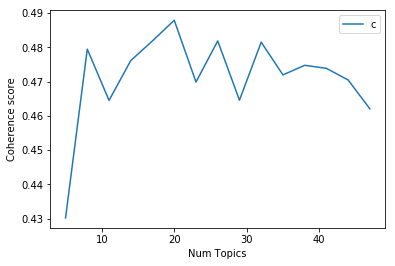

In [50]:
# Show graph
limit=50; start=5; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [51]:
# Print the coherence scores
i =0
for m, cv in zip(x, coherence_values):
    print("Index = ",i,"Num Topics =", m, " has Coherence Value of", round(cv, 4))
    i = i+1


Index =  0 Num Topics = 5  has Coherence Value of 0.4302
Index =  1 Num Topics = 8  has Coherence Value of 0.4795
Index =  2 Num Topics = 11  has Coherence Value of 0.4645
Index =  3 Num Topics = 14  has Coherence Value of 0.4761
Index =  4 Num Topics = 17  has Coherence Value of 0.4819
Index =  5 Num Topics = 20  has Coherence Value of 0.4879
Index =  6 Num Topics = 23  has Coherence Value of 0.4699
Index =  7 Num Topics = 26  has Coherence Value of 0.4819
Index =  8 Num Topics = 29  has Coherence Value of 0.4646
Index =  9 Num Topics = 32  has Coherence Value of 0.4815
Index =  10 Num Topics = 35  has Coherence Value of 0.4719
Index =  11 Num Topics = 38  has Coherence Value of 0.4747
Index =  12 Num Topics = 41  has Coherence Value of 0.4739
Index =  13 Num Topics = 44  has Coherence Value of 0.4705
Index =  14 Num Topics = 47  has Coherence Value of 0.462


We can see the score line is not quite regular but overall there is a limitation at 0.385. Although choosing higher topic numbers may reach higher performance, it cannot explain itself. 

So for further steps I will choose the model with 12 topics which is an adequate topic amount.



In [53]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.044*"engineering" + 0.031*"programming" + 0.026*"workshop" + '
  '0.018*"engineer" + 0.018*"robot" + 0.016*"compute" + 0.016*"computational" '
  '+ 0.015*"block" + 0.013*"maker" + 0.013*"computing"'),
 (1,
  '0.041*"gesture" + 0.035*"mathematical" + 0.020*"body" + 0.019*"embody" + '
  '0.016*"movement" + 0.013*"episode" + 0.013*"spatial" + 0.011*"motion" + '
  '0.009*"math" + 0.009*"speech"'),
 (2,
  '0.029*"literacy" + 0.018*"reading" + 0.016*"designer" + 0.014*"stage" + '
  '0.010*"dbr" + 0.010*"studio" + 0.010*"product" + 0.009*"definition" + '
  '0.009*"reader" + 0.009*"presentation"'),
 (3,
  '0.064*"lesson" + 0.014*"pedagogical" + 0.013*"scaffold" + '
  '0.012*"whole_class" + 0.012*"professional_development" + 0.012*"enactment" '
  '+ 0.011*"enact" + 0.010*"planning" + 0.009*"ownership" + '
  '0.009*"elementary"'),
 (4,
  '0.052*"youth" + 0.051*"identity" + 0.033*"stem" + 0.015*"woman" + '
  '0.014*"scientist" + 0.013*"power" + 0.012*"equity" + 0.010*"gender" + '
  '0.0

Those were the topics for the chosen LDA model.

In [48]:
# Build LDA model
optimal_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_lda_model, corpus, id2word)
vis

/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      11.483685        1       1  0.058060 -0.037621
2      10.723128        1       2 -0.068753 -0.100928
16      9.061659        1       3  0.205840  0.002421
12      8.615092        1       4  0.067856 -0.027191
10      6.581605        1       5  0.104093 -0.101361
7       6.502128        1       6 -0.008316 -0.182622
0       6.006733        1       7  0.187399  0.030448
18      5.848553        1       8 -0.165247 -0.088424
9       5.351364        1       9 -0.178928 -0.185679
6       3.875273        1      10 -0.014973  0.156949
5       3.851641        1      11 -0.133954  0.006811
17      3.077428        1      12  0.221753  0.014725
14      2.962030        1      13 -0.120935  0.046147
3       2.673382        1      14 -0.070725 -0.014048
8       2.622006        1      15  0.165028 -0.045150
15      2.600090        1      16 -0.081476  0.251557
13      2.359879        1      17 -0.045755  0.257576
1       2.196701        1      18 -0.141372  0.054268
19      1.907439        1      19 -0.040093 -0.063261
11      1.700176        1      20  0.060498  0.025383, topic_info=     Category         Freq                      Term        Total  loglift  \
term                                                                         
2492  Default  3454.000000                      game  3454.000000  30.0000   
1922  Default  2130.000000                   gesture  2130.000000  29.0000   
1216  Default  1858.000000                    lesson  1858.000000  28.0000   
3461  Default  1692.000000                   partner  1692.000000  27.0000   
3924  Default  2020.000000                     youth  2020.000000  26.0000   
2969  Default  1544.000000              mathematical  1544.000000  25.0000   
1906  Default  1690.000000                    energy  1690.000000  24.0000   
3556  Default  1919.000000                  identity  1919.000000  23.0000   
2671  Default  1630.000000              disciplinary  1630.000000  22.0000   
545   Default  2211.000000                   network  2211.000000  21.0000   
3575  Default  1740.000000                 epistemic  1740.000000  20.0000   
1435  Default  1462.000000               facilitator  1462.000000  19.0000   
3389  Default  1492.000000                simulation  1492.000000  18.0000   
3641  Default  1431.000000                 scientist  1431.000000  17.0000   
3894  Default  1316.000000                     light  1316.000000  16.0000   
3853  Default  1338.000000                    family  1338.000000  15.0000   
1666  Default  1088.000000               progression  1088.000000  14.0000   
3427  Default  1065.000000  professional_development  1065.000000  13.0000   
3562  Default  1194.000000                     tutor  1194.000000  12.0000   
3496  Default  1470.000000                  workshop  1470.000000  11.0000   
1997  Default  1138.000000                      dyad  1138.000000  10.0000   
445   Default  1902.000000                      stem  1902.000000   9.0000   
426   Default  1786.000000                  argument  1786.000000   8.0000   
1432  Default   827.000000                 awareness   827.000000   7.0000   
2714  Default   798.000000             self_efficacy   798.000000   6.0000   
1799  Default  1258.000000                      item  1258.000000   5.0000   
868   Default   944.000000                discipline   944.000000   4.0000   
3670  Default  1400.000000                     phase  1400.000000   3.0000   
67    Default  1408.000000             argumentation  1408.000000   2.0000   
3533  Default   740.000000                multimodal   740.000000   1.0000   
...       ...          ...                       ...          ...      ...   
1832  Topic20    37.887268               conflicting    55.042542   3.7009   
2519  Topic20    16.500406                 territory    24.321571   3.6865   
4163  Topic20    16.531887             

### Finding the dominant topic in each paper
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [54]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=contents):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
#         print(i)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=contents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.3918,"literacy, reading, designer, stage, dbr, studi...",Teaching Struggling Middle School Readers\nto ...
1,1,4.0,0.2855,"youth, identity, stem, woman, scientist, power...",Becoming a Computer Scientist: Early Results o...
2,2,11.0,0.3439,"conflict, belief, dimension, emotion, attitude...","Science, Technology, Body and Personhood: The ..."
3,3,15.0,0.3351,"network, analytic, gaze, cluster, visualizatio...",“With-Me-Ness”: A Gaze-Measure for Students’ A...
4,4,11.0,0.5711,"conflict, belief, dimension, emotion, attitude...",The Role of Inconsistencies in Collaborative K...
5,5,19.0,0.2091,"argumentation, claim, argument, revision, crit...",A Design Inquiry: Bridging Assessment and Curr...
6,6,9.0,0.2905,"instructor, post, survey, mooc, assignment, se...",Design Principles for Motivating Learning with...
7,7,14.0,0.1995,"user, display, proceedings_isls, app, interfac...",What’s Happening in the “Quantified Self” Move...
8,8,17.0,0.4786,"energy, light, water, mechanism, uncertainty, ...",The Nature of Student Thinking and Its Implica...
9,9,1.0,0.4594,"gesture, mathematical, body, embody, movement,...",Teaching about Confidence Intervals:\nHow Inst...


### Find the most representative document for each topic
This is the way to find out what is a topic about. 

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, we can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [55]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6025,"engineering, programming, workshop, engineer, ...",Expanding the Maker Movement by Recentering “B...
1,1.0,0.7089,"gesture, mathematical, body, embody, movement,...",Collaborative Gesture as a Case of Distributed...
2,2.0,0.6129,"literacy, reading, designer, stage, dbr, studi...",Facilitating Design Research by Mapping Design...
3,3.0,0.5741,"lesson, pedagogical, scaffold, whole_class, pr...",Supporting Pre-Service Science Teachers’ Plann...
4,4.0,0.6436,"youth, identity, stem, woman, scientist, power...",Fighting for Desired Versions of a Future Self...


In [56]:
sent_topics_sorteddf_mallet[sent_topics_sorteddf_mallet.Keywords.str.contains('mooc')]

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
9,9.0,0.6054,"instructor, post, survey, mooc, assignment, se...",How Technology and Collaboration Promote Forma...


The tabular output above actually has 15 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

### Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [215]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

In [186]:
topic_prop = []
ind = 0
for n in time_slice:
    topic_prop.append(optimal_model[[item for sublist in corpus[ind: ind+n] for item in sublist]])
    ind = ind + n

In [211]:
count_df = pd.DataFrame()
year = 2014
for t in topic_prop:
    df = pd.DataFrame(t)
    df['year'] = year
    if (year%2):
        df['conf'] = 'CSCL'
    else:
        df['conf'] = 'ICLS'
    count_df = pd.concat((count_df, df), axis=0)
    year = year + 1
count_df.columns = ['topic', 'proportion','year','conf']
count_df =count_df.reset_index()
count_df.head()

,index,topic,proportion,year,conf
0,0,0,0.035875,2014,ICLS
1,1,1,0.057774,2014,ICLS
2,2,2,0.051642,2014,ICLS
3,3,3,0.055868,2014,ICLS
4,4,4,0.069763,2014,ICLS


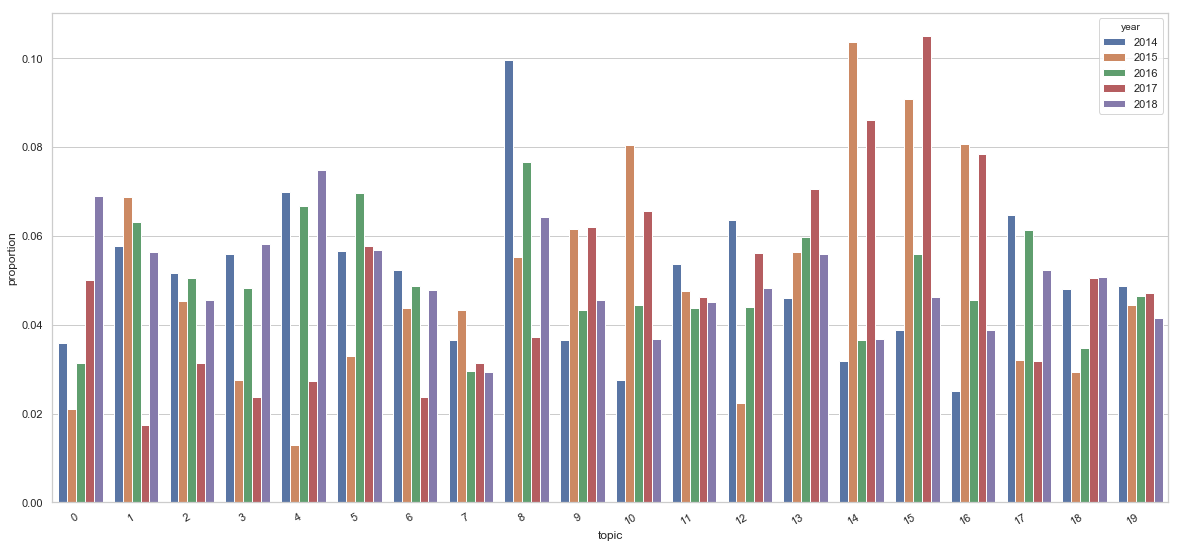

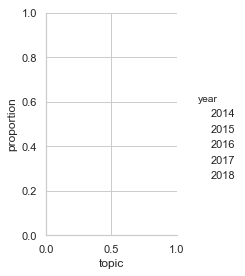

In [209]:
fig,ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(20, 10)

sns.catplot(x="topic", y="proportion",hue='year',
                data=count_df, kind="bar",
                height=4, aspect=.7,ax = ax)

# figure size in inches
fig.autofmt_xdate()

/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


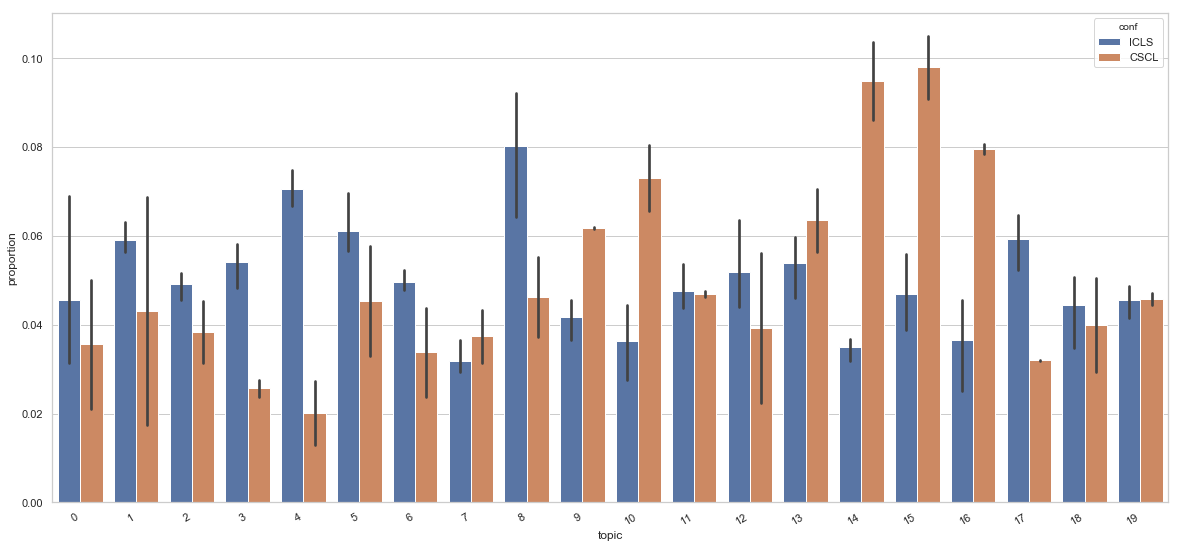

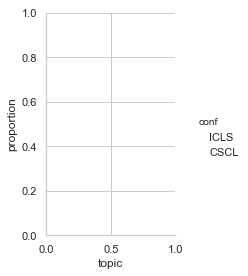

In [214]:
fig,ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(20, 10)

sns.catplot(x="topic", y="proportion",hue='conf',
                data=count_df, kind="bar",
                height=4, aspect=.7,ax = ax)

# figure size in inches
fig.autofmt_xdate()

## Dynamic topic modeling

In [59]:
# Build LDA seq model

from gensim.models import ldaseqmodel
%time ldaseq_model = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=id2word, time_slice=time_slice, num_topics=20)

/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/gensim/models/ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/gensim/models/ldaseqmodel.py:296: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/gensim/models/ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/gensim/models/ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/Users/zhenchensu/anaconda2/envs/ada/lib/python3.5/site-packages/gensim/models/ldaseqmodel.py:1478: RuntimeW

CPU times: user 10h 40min 24s, sys: 1min 47s, total: 10h 42min 12s
Wall time: 10h 45min


In [60]:
from gensim.test.utils import datapath
temp_file = datapath("ldaseq_model")
ldaseq_model.save(temp_file)

# Load a potentially pre-trained model from disk.
ldaseq_model = ldaseqmodel.LdaSeqModel.load(temp_file)

In [61]:
import seaborn as sns
def print_topic_change(topic=0, top_terms=10):
    df_time = pd.DataFrame()
    t=ldaseq_model.print_topic_times(topic=topic,top_terms=top_terms)
    for i in range(len(t)):
        temp = pd.DataFrame(t[i], columns=['word', 'value'])
        temp['year'] = 2014 + i 
        df_time = pd.concat([df_time, temp])
    # Line plot
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_style("whitegrid")
    ax = sns.lineplot(x='year', y='value',
                      hue="word", markers=True, dashes=False, data=df_time)
    plt.legend(loc='upper right')
    plt.xticks([2014, 2015, 2016, 2017, 2018])

In [62]:
pd.DataFrame(ldaseq_model.print_topics(top_terms=6))

,0,1,2,3,4,5
0,"(simulation, 0.03328509135335243)","(tutor, 0.014499348756425057)","(prompt, 0.01333654118196377)","(transfer, 0.01006586899444657)","(complex_system, 0.00953827574320716)","(virtual, 0.00896066947006636)"
1,"(script, 0.014672389161837787)","(argumentation, 0.012942769835685564)","(attitude, 0.010684617688872784)","(instructor, 0.010436760130350196)","(comment, 0.009783244450430151)","(active, 0.009235995858731107)"
2,"(regulation, 0.020165476643560568)","(user, 0.019009620572050825)","(mobile, 0.011009474606532097)","(metacognitive, 0.010494611114669717)","(app, 0.010482736779793882)","(agent, 0.008928454920421484)"
3,"(engineering, 0.029578171341748328)","(engineer, 0.012268147539968795)","(professional, 0.0117033841530897)","(identity, 0.010034883869992293)","(disciplinary, 0.009712257401649022)","(culture, 0.008362372647723779)"
4,"(network, 0.06274597494592042)","(map, 0.020298126102805104)","(visualization, 0.018065306589255026)","(visitor, 0.01638326568730175)","(museum, 0.01572831224342233)","(exhibit, 0.01538532947480196)"
5,"(lesson, 0.04133284272832554)","(epistemic, 0.03502114670494142)","(collective, 0.02121174341557543)","(authentic, 0.007939944012526668)","(scientist, 0.007470559265643664)","(light, 0.00647417389693162)"
6,"(graph, 0.023556512694536215)","(claim, 0.020492208163572615)","(revision, 0.015016423517055113)","(critique, 0.013486299036224995)","(argument, 0.01187491521409206)","(item, 0.009919847817654285)"
7,"(programming, 0.028036210698890097)","(computational, 0.017995107720842167)","(robot, 0.015324779800779805)","(block, 0.011345812281720763)","(compute, 0.010601645498621243)","(computing, 0.010528356317997489)"
8,"(gesture, 0.03150830745721916)","(mathematical, 0.024813982841730062)","(body, 0.013368557070841823)","(embody, 0.011956477350178516)","(movement, 0.0071327509068112045)","(speech, 0.006744868836833084)"
9,"(physics, 0.029402084116838607)","(particle, 0.010844331506103023)","(force, 0.00992637026200375)","(episode, 0.009210705985908115)","(mechanism, 0.00797231014537035)","(motion, 0.007618132088689231)"


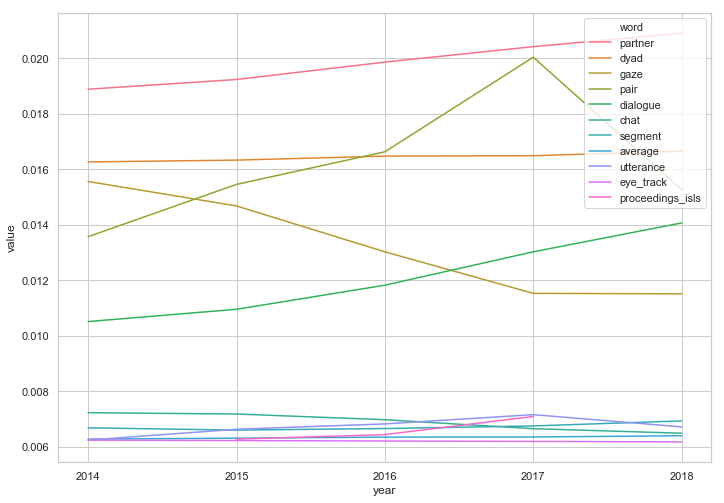

In [104]:
print_topic_change(topic=19, top_terms=10)

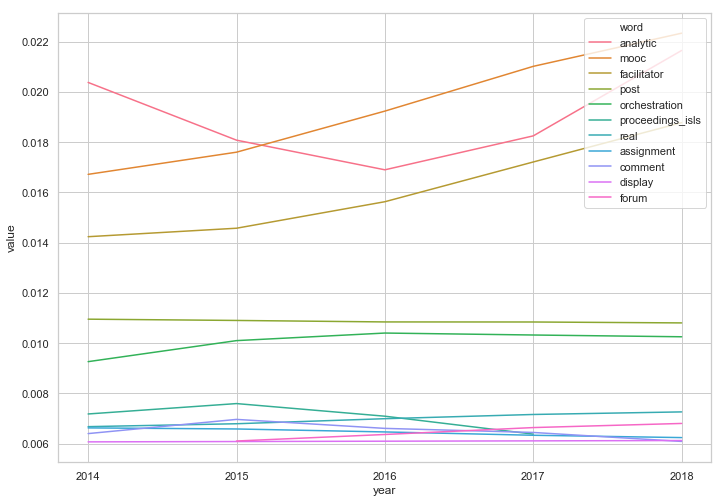

In [98]:
print_topic_change(topic=16, top_terms=10)

## The author-topic model
The author-topic model is an extension of Latent Dirichlet Allocation (LDA), that allows us to learn topic representations of authors in a corpus.

In [65]:
#get information about author and document id
docid_pd = pd.DataFrame.from_dict(docid, orient='index')
docid_pd.columns = ['file']
docid_pd['id'] = docid_pd.index

author_data = pd.read_csv('author_data.csv')
author_data = author_data.merge(docid_pd, on='file')
author_data.head()

,file,title,long_name,author_order_y,shortend_names,id
0,2018_14,Encountering and Becoming Role Models: Combati...,"Hinojosa, Leighanna",0,Hinojosa L.,684
1,2016_39,"Mobilities of Criticality: Space-Making, Ident...","Barton, Angela Calabrese",0,Barton A. C.,500
2,2016_39,"Mobilities of Criticality: Space-Making, Ident...","Tan, Edna",1,Tan E.,500
3,2016_39,"Mobilities of Criticality: Space-Making, Ident...","Shin, Myunghwan",2,Shin M.,500
4,2018_28,Redistributing Epistemic Agency: How Teachers ...,"Ko, Monlin",0,Ko M.,813


In [66]:
author_data[author_data.long_name.str.contains(' Pierre')]

,file,title,long_name,author_order_y,shortend_names,id
86,2016_175,Real-Time Visualization of Student Activities ...,"Dillenbourg, Pierre",14,Dillenbourg P.,476
240,2016_174,The Learning Sciences @ Scale: Current Develop...,"Dillenbourg, Pierre",3,Dillenbourg P.,475
943,2016_28,Visual Augmentation of Deictic Gestures in MOO...,"Dillenbourg, Pierre",3,Dillenbourg P.,489
1791,2015_206,The Burden of Facilitating Collaboration: Towa...,"Dillenbourg, Pierre",3,Dillenbourg P.,341
2036,2017_116,"CSCL and Eye-Tracking: Experiences, Opportunit...","Dillenbourg, Pierre",2,Dillenbourg P.,582
2658,2015_182,3D Tangibles Facilitate Joint Visual Attention...,"Dillenbourg, Pierre",4,Dillenbourg P.,334
2966,2016_68,Detecting Collaborative Dynamics Using Mobile ...,"Dillenbourg, Pierre",4,Dillenbourg P.,529
2982,2018_79,Interlacing Gaze and Actions to Explain the De...,"Dillenbourg, Pierre",3,Dillenbourg P.,1119
3732,2015_254,Orchestration Challenges Raised by Transposing...,"Tchounikine, Pierre",1,Tchounikine P.,352
3793,2015_250,Looking AT versus Looking THROUGH: A Dual Eye-...,"Dillenbourg, Pierre",4,Dillenbourg P.,350


In [67]:
#Create author2doc
author2doc = dict()
t = author_data[['long_name', 'id']].drop_duplicates()
for index, row in t.iterrows():
    author_name = row.long_name
    if not author2doc.get(author_name):
        # This is a new author.
        author2doc[author_name] = []
        i += 1

    # Add document IDs to author.
    author2doc[author_name].extend([row.id])
author2doc

{'Bruton, Rebecca': [793],
 'Pryputniewicz, Sarah': [595],
 'Phillips, Anna McLean': [758],
 'Mahoney, Charlie': [520],
 'Blair, Kristen P.': [37],
 'Mote, Chad': [42],
 'Zhou, He': [783, 755],
 'Krinks, Kara': [63],
 'Reiss, Kristina': [382, 540],
 'Livingston, Ayesha': [148],
 'Wen, Yun': [341, 357, 780],
 'Hinojosa, Leighanna': [684, 565, 905, 915, 443],
 'Heyd-Metzuyanim, Einat': [976, 155, 64],
 'Im, Soo-hyun': [766],
 'Reich, Justin': [1121],
 'Sawtelle, Vashti': [30],
 'Bod, Petra': [830],
 'De Wever, Bram': [654],
 'Ryberg, Thomas': [322],
 'Goh, Wendy': [563, 413],
 'Tang, Kok-Sing': [225],
 'Verma, Himanshu': [350],
 'Wartella, Ellen': [48],
 'Crowley, Kevin': [984],
 'Anjewierden, Anjo': [407],
 'Anderson, Theresa Dirndorfer': [730],
 'Zahid, Aejaz': [354],
 'Hossain, Zahid': [710],
 'Cain, Ryan': [473],
 'Wright, Kenneth': [660],
 'Levenson, Eda': [1000],
 'Morphew, Jason': [457],
 'Tan, Yuanru': [859],
 'Eimler, Sabrina': [379],
 'Sherin, Miriam': [65],
 'Oshima, Jun': [10

In [68]:
print('Number of authors: %d' % len(author2doc))
print('Number of documents: %d' % len(corpus))

Number of authors: 2282
Number of documents: 1125


In [83]:
#Train
from gensim.models import AuthorTopicModel
%time model = AuthorTopicModel(corpus=corpus, num_topics=20, id2word=id2word, \
                author2doc=author2doc, chunksize=2000, passes=1, eval_every=0, \
                iterations=1, random_state=1)

CPU times: user 1.62 s, sys: 218 ms, total: 1.84 s
Wall time: 1.22 s


In [84]:
%%time
model_list = []
for i in range(5):
    model = AuthorTopicModel(corpus=corpus, num_topics=20, id2word=id2word, \
                    author2doc=author2doc, chunksize=2000, passes=100, gamma_threshold=1e-10, \
                    eval_every=0, iterations=1, random_state=i)
    top_topics = model.top_topics(corpus)
    tc = sum([t[1] for t in top_topics])
    model_list.append((model, tc))

CPU times: user 7min 42s, sys: 1min 1s, total: 8min 43s
Wall time: 4min 27s


Choose the model with the highest topic coherence.

In [85]:
model, tc = max(model_list, key=lambda x: x[1])
print('Topic coherence: %.3e' %tc)

Topic coherence: -3.226e+01


In [86]:
# Save model.
model.save('model.atmodel')
# Load model.
model = AuthorTopicModel.load('model.atmodel')

### Explore author-topic representation
Now that we have trained a model, we can start exploring the authors and the topics.

First, let's simply print the most important words in the topics. Below we have printed topic 0. As we can see, each topic is associated with a set of words, and each word has a probability of being expressed under that topic.

In [92]:
model.show_topic(11)

[('programming', 0.02326302926080441),
 ('workshop', 0.021673452171328725),
 ('compute', 0.01245412951267526),
 ('scratch', 0.010698445725722068),
 ('computing', 0.010534241255325894),
 ('block', 0.009424186767848968),
 ('app', 0.00908278012819067),
 ('computational', 0.009018484508643147),
 ('maker', 0.008599842478327175),
 ('parent', 0.008212544748308275)]

In [90]:
model['Dillenbourg, Pierre']

[(15, 0.9992625072829993)]

In [95]:
from pprint import pprint
topic_labels = range(20)
def show_author(name):
    print('\n%s' % name)
    print('Docs:', model.author2doc[name])
    print('Topics:')
    pprint([(topic_labels[topic[0]], topic[1]) for topic in model[name]])

In [96]:
show_author('Dillenbourg, Pierre')


Dillenbourg, Pierre
Docs: [476, 475, 489, 341, 582, 334, 529, 1119, 350]
Topics:
[(15, 0.9992625072829993)]


In [110]:
show_author('Rummel, Nikol')


Rummel, Nikol
Docs: [1006, 393, 310, 673, 303, 366, 675, 781, 689, 928, 378, 435, 381, 759, 582, 952, 433, 506, 530, 37, 590, 66, 803, 351]
Topics:
[(15, 0.9996504931797144)]


In [117]:
model.show_topic(15)

[('phase', 0.01472270114267212),
 ('dyad', 0.012474235904633011),
 ('pair', 0.011292923869317241),
 ('tutor', 0.010357332636378119),
 ('gaze', 0.010194871802817572),
 ('visual', 0.009316086983624655),
 ('prompt', 0.0070943984011144),
 ('sequence', 0.006707337591095699),
 ('hypothesis', 0.006464376032993503),
 ('correct', 0.0064608368030673775)]

### Plotting the authors
Now we're going to produce the kind of pacific archipelago looking plot below. The goal of this plot is to give you a way to explore the author-topic representation in an intuitive manner.

We take all the author-topic distributions (stored in model.state.gamma) and embed them in a 2D space. To do this, we reduce the dimensionality of this data using t-SNE.

t-SNE is a method that attempts to reduce the dimensionality of a dataset, while maintaining the distances between the points. That means that if two authors are close together in the plot below, then their topic distributions are similar.

In the cell below, we transform the author-topic representation into the t-SNE space. We can increase the smallest_author value if you do not want to view all the authors with few documents.

In [120]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
smallest_author = 2  # Ignore authors with documents less than this.
authors = [model.author2id[a] for a in model.author2id.keys() if len(model.author2doc[a]) >= smallest_author]
_ = tsne.fit_transform(model.state.gamma[authors, :])  # Result stored in tsne.embedding_

CPU times: user 4.04 s, sys: 20.3 ms, total: 4.06 s
Wall time: 4.09 s


In [121]:
# Tell Bokeh to display plots inside the notebook.
from bokeh.io import output_notebook
output_notebook()
from bokeh.models import HoverTool
from bokeh.plotting import figure, show, ColumnDataSource

x = tsne.embedding_[:, 0]
y = tsne.embedding_[:, 1]
author_names = [model.id2author[a] for a in authors]

# Radius of each point corresponds to the number of documents attributed to that author.
scale = 0.1
author_sizes = [len(model.author2doc[a]) for a in author_names]
radii = [size * scale for size in author_sizes]

source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            author_names=author_names,
            author_sizes=author_sizes,
            radii=radii,
        )
    )

# Add author names and sizes to mouse-over info.
hover = HoverTool(
        tooltips=[
        ("author", "@author_names"),
        ("size", "@author_sizes"),
        ]
    )

p = figure(tools=[hover, 'crosshair,pan,wheel_zoom,box_zoom,reset,save,lasso_select'])
p.scatter('x', 'y', radius='radii', source=source, fill_alpha=0.6, line_color=None)
show(p)

Loading BokehJS ...

The circles in the plot above are individual authors, and their sizes represent the number of documents attributed to the corresponding author. 

In [218]:
#the percentage of author have more than 1 
sum(author_data.long_name.value_counts()>5)/sum(author_data.long_name.value_counts()>0)
sum(author_data.long_name.value_counts()>5)

96

Each year, most of authors have less than 1 paper per year and it is coresponded to real situation. If we use this one or two papers to indicate a author's preference, the preference problem is reduced to document feature. For example, assume we want to compare two authors with few papers, it is likely to get large bias and is more directly to compare similarity between documents which already implemented in the first part of notebook. Thus, we need to consider author's papers all the time to make firm and steady preference. 

In [151]:
# Make a function that returns similarities based on the Hellinger distance.

from gensim import matutils
import pandas as pd

# Make a list of all the author-topic distributions.
author_vecs = [model.get_author_topics(author) for author in model.id2author.values()]

def similarity(vec1, vec2):
    '''Get similarity between two vectors'''
    dist = matutils.hellinger(matutils.sparse2full(vec1, model.num_topics), \
                              matutils.sparse2full(vec2, model.num_topics))
    sim = 1.0 / (1.0 + dist)
    return sim

def get_sims(vec):
    '''Get similarity of vector to all authors.'''
    sims = [similarity(vec, vec2) for vec2 in author_vecs]
    return sims

def get_table(name, top_n=10, smallest_author=2):
    '''
    Get table with similarities, author names, and author sizes.
    Return `top_n` authors as a dataframe.
    
    '''
    
    # Get similarities.
    sims = get_sims(model.get_author_topics(name))

    # Arrange author names, similarities, and author sizes in a list of tuples.
    table = []
    for elem in enumerate(sims):
        author_name = model.id2author[elem[0]]
        sim = elem[1]
        author_size = len(model.author2doc[author_name])
        if author_size >= smallest_author:
            table.append((author_name, sim, author_size))
            
    # Make dataframe and retrieve top authors.
    df = pd.DataFrame(table, columns=['Author', 'Score', 'Size'])
    df = df.sort_values('Score', ascending=False)[:top_n]
    topic = []
    for name in df.Author:
        topic.append(sorted(model[name], key=lambda x: (x[1]), reverse=True) )
    df['topic'] = topic
    return df


In [152]:
get_table('Dillenbourg, Pierre')

,Author,Score,Size,topic
140,"Dillenbourg, Pierre",1.000000,9,"[(15, 0.9992625072829993)]"
6,"Aleven, Vincent",0.999943,9,"[(15, 0.9994224930345023)]"
547,"Sharma, Kshitij",0.999909,10,"[(15, 0.9995202787624535)]"
488,"Rau, Martina A.",0.999868,7,"[(15, 0.9996350170183851)]"
511,"Rummel, Nikol",0.999863,24,"[(15, 0.9996504931797144)]"
195,"Giannakos, Michail",0.999182,2,"[(15, 0.9969496998568755)]"
274,"Jermann, Patrick",0.919429,2,"[(15, 0.9808736393393374), (17, 0.015273107437..."
155,"D’Angelo, Sarah",0.858539,2,"[(15, 0.9434017563303392), (5, 0.0315718483412..."
438,"Olsen, Jennifer K.",0.845866,6,"[(15, 0.9339390405290787), (13, 0.043391190297..."
362,"Loibl, Katharina",0.824355,6,"[(15, 0.9105749412308609), (12, 0.088736768904..."


In [146]:
show_author('Loibl, Katharina')


Loibl, Katharina
Docs: [393, 378, 530, 37, 791, 351]
Topics:
[(12, 0.08873676890441612), (15, 0.9105749412308609)]


### With sklearn
With LDA using gensim, topics cannot separate obviously. In this part, we are going to employ LDA in sklearn library which can provide a different point of view.

With scikit learn, we have an entirely different interface and with grid search and vectorizers.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

### Tokenize and Clean-up using gensim’s simple_preprocess()
This part is done by gensim section, so we can use data_words directly.

In [ ]:
# def sent_to_words(sentences):
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# data_words = list(sent_to_words(contents))

# print(data_words[:1])


### Lemmatization
Lemmatization is a process where we convert words to its root word.

For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’

The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns.

We can expect better topics to be generated in the end.


In [ ]:
def lemmatization(texts):
    texts_out = []
    for sent in texts:
        doc = ''
        for word in sent:
            doc = doc + ' ' + stemmer.stem(word) 
        texts_out.append(doc)
    return texts_out

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words)

print(data_lemmatized[2])

### Create the Document-Word matrix
The LDA topic model algorithm requires a document word matrix as the main input.

We create one using CountVectorizer. In the below code, I have configured the CountVectorizer to consider words that has occurred at least 20 times (min_df), remove built-in english stopwords, convert all words to lowercase, and a word can contain numbers and alphabets of at least length 3 in order to be qualified as a word.

In [ ]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=20,                        # minimum reqd occurences of a word 
                             max_df=0.8,
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

### Check the Sparsicity
Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.

In [ ]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

### Build LDA model with sklearn
Everything is ready to build a Latent Dirichlet Allocation (LDA) model. I have set the n_topics as 20 based on prior knowledge about the dataset. Later we will find the optimal number using grid search.

In [ ]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

### Diagnose model performance with perplexity and log-likelihood
A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

In [ ]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

### GridSearch the best model
The most important tuning parameter for LDA models is n_components (number of topics). In addition, I am going to search learning_decay (which controls the learning rate) as well.


In [ ]:
# Define Search Param
search_params = {'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

### Best topic model and its parameters


In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

### Compare LDA Model Performance Scores
Plotting the log-likelihood scores against num_topics, clearly shows number of topics = 10 has better scores. And learning_decay of 0.9 outperforms both 0.5 and 0.7.

In [ ]:
results_df = pd.DataFrame(model.cv_results_)
results_df.head()

In [ ]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = np.round(list(results_df.groupby('param_learning_decay').mean_test_score)[0][1].values.tolist())
log_likelyhoods_7 = np.round(list(results_df.groupby('param_learning_decay').mean_test_score)[1][1].values.tolist())
log_likelyhoods_9 = np.round(list(results_df.groupby('param_learning_decay').mean_test_score)[2][1].values.tolist())

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [ ]:
np.log(abs(log_likelyhoods_7))

### Dominant topic in each document?
To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.

In [ ]:
best_lda_model

In [ ]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(contents))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

###  Review topics distribution across documents

In [ ]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

### Visualize the LDA model with pyLDAvis
The pyLDAvis offers the best visualization to view the topics-keywords distribution.

A good topic model will have non-overlapping, fairly big sized blobs for each topic. This seems to be the case here. 


In [ ]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

### Topic’s keywords?
The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().

Let’s use this info to construct a weight matrix for all keywords in each topic.

In [ ]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

### Get the top 15 keywords each topic
From the above output, I want to see the top 15 keywords that are representative of the topic.

The show_topics() defined below creates that.

In [ ]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

### Cluster documents that share similar topics and plot?
We use k-means clustering on the document-topic probabilioty matrix, which is nothing but lda_output object. Since out best model has 15 clusters, I’ve set n_clusters=15 in KMeans().

Alternately, we could avoid k-means and instead, assign the cluster as the topic column number with the highest probability score.

We now have the cluster number. But we also need the X and Y columns to draw the plot.

For the X and Y, we use SVD on the lda_output object with n_components as 2. SVD ensures that these two columns captures the maximum possible amount of information from lda_output in the first 2 components.

In [ ]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

In [ ]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )